In [1]:
import SIRD_Model

import numpy as np
import csv
import matplotlib.pyplot as plt
import platform

In [6]:
from sklearn import linear_model

def approxRecovered(infect):
    recovG = np.zeros(len(infect))
    for i in range(len(infect) - 13):
        recovG[i + 13] = infect[i] - dead[i + 13]
    return recovG

#note paramArg is in the format of [q, beta, gamma, nu] [q, b1, b2, b3, b0, b1, gamma, nu]
def errorSIRD(paramArg, pop, I, R, D, lamda, w): #the custom error function for SIRD    
    
    q = paramArg[0]
    b = [paramArg[-4], paramArg[-3], paramArg[1], paramArg[2], paramArg[3]] #b=[b0, b1, b2, b3, b4]
    
    params = paramArg[:-4] #beta0, gamma, nu
    
    #note: beta = b0 / (1 + (I*b1 + D*b2)^b3)
    #use b0 in the place of beta, and multiply first column by 1/(1+(I*b1+D*b2)^b3)
    
    S = q*pop - I - R - D #q*Pop = S + I + R + D
    
    y, A = SIRD_Model.getSIRDMatrices(S, I, R, D)
    
    wideA = np.zeros((np.shape(A)[0], np.shape(A)[1], np.shape(A)[2] + 1)) #add column for b0
    wideA[:,:,1:] = A #copy over matrix
    wideA[:,0,0] = A[:,0,0] #copy over -b0 * SI/S+I
    wideA[:,1,0] = A[:,1,0] #copy over b0 * SI/S+I

    betaTransform = calculateBeta([0,1,b[1],b[2],b[3]], I, R, D, pop,q) #use zero/one for b0/b1, since they aren't solved for yet
    wideA[:,0,1] = wideA[:,0,1] * betaTransform
    wideA[:,1,1] = wideA[:,1,1] * betaTransform
    
    totalError = 0
    #see paper for optimization function
    T = len(A)
    for t in range(T):
        totalError = totalError + (w**(T - t))*(np.linalg.norm((wideA[t] @ params) - y[t].transpose(), ord=2)**2)
    
    #return (1.0/T) * np.linalg.norm((A @ params) - y.transpose(), ord=2)**2  + lamda*np.linalg.norm(params, ord=1)
    totalError = (1.0/T)*totalError #divide by timeframe
    totalError = totalError + lamda*np.linalg.norm(params, ord=1) #regularization error
    return totalError

def getLinVarsSIRD(paramArg, pop, I, R, D, lamda, w): #calculate the linear vars for the SIRD model, b0, gamma, nu  
    
    q = paramArg[0]
    b1 = paramArg[1]
    b2 = paramArg[2]
    b3 = paramArg[3]
    
    #b0, b1, gamma, nu should be solved for
    
    #note: beta = b0 / (1 + (I*b1 + D*b2)^b3)
    
    S = q*pop - I - R - D #q*Pop = S + I + R + D

    nextIterMatrix, sirdMatrix = SIRD_Model.getSIRDMatricesFlat(S,I,R,D)
    T = int(len(nextIterMatrix)/4)
    wideSirdMatrix = np.zeros((T*4, np.shape(sirdMatrix)[1] + 1)) #column for b0
    wideSirdMatrix[:,1:] = sirdMatrix #copy over columns
    
    #construct y and A, see paper for solving the lasso optimization
    y = np.zeros( (T*4, 1) )
    A = np.zeros( (T*4, np.shape(wideSirdMatrix)[1]) )
    
    betaTransform = calculateBeta([0,1,b1,b2,b3], I, R, D, pop,q) #use zero/one for b0, b1, since they arent't solved for yet
    for t in range(T):
        wideSirdMatrix[4*t+0,0] = sirdMatrix[4*t+0,0] # -b0*SI/S+I
        wideSirdMatrix[4*t+1,0] = sirdMatrix[4*t+1,0] # b0*SI/S+I
        
        y[4*t+0] = nextIterMatrix[4*t+0] * np.sqrt(w**(T - t))
        y[4*t+1] = nextIterMatrix[4*t+1] * np.sqrt(w**(T - t))
        y[4*t+2] = nextIterMatrix[4*t+2] * np.sqrt(w**(T - t))
        y[4*t+3] = nextIterMatrix[4*t+3] * np.sqrt(w**(T - t))

        #transform location where beta is needed and multiply by 1/(1+(I*b1+D*b2)^b3)
        wideSirdMatrix[4*t+0,1] = wideSirdMatrix[4*t+0,1] * betaTransform[t]
        wideSirdMatrix[4*t+1,1] = wideSirdMatrix[4*t+1,1] * betaTransform[t]
        
        A[4*t+0] = wideSirdMatrix[4*t+0] * np.sqrt(w**(T - t))
        A[4*t+1] = wideSirdMatrix[4*t+1] * np.sqrt(w**(T - t))
        A[4*t+2] = wideSirdMatrix[4*t+2] * np.sqrt(w**(T - t))
        A[4*t+3] = wideSirdMatrix[4*t+3] * np.sqrt(w**(T - t))
            
    
    try:
        model = linear_model.Lasso(alpha=lamda, fit_intercept=False, positive=True)
        model.fit(A,y)
        params = model.coef_
    except: #did not converge set params to zero
        params = np.zeros((np.shape(A)[1]))
        #print("linal didn't converge")
    
    #totalError = (1.0/T) * np.linalg.norm((A @ params) - y.transpose(), ord=2)**2  + lamda*np.linalg.norm(params, ord=1)
    return list(params)

def gridNonLinVars(constraints, varResols, pop, I, R, D, lamda, w): #solve for non linear vars, q, b1, b2, b3
    
    #varSteps[:] = constraints[:][0] + (constraints[:][1] - constraints[:][0])/varResols[:]
    varSteps = []
    for i in range(len(constraints)):
        varSteps.append(constraints[i][0] + (constraints[i][1] - constraints[i][0])/varResols[i]) #min + (max - min)/resol
        if(varSteps[-1] == 0):
            varSteps[-1] = 1 #avoids infinite loop and zero step movement
            
    #note beta = b0/(1 + (b1*I + b2*D)^b3)
    #assume starting vals as best starting value
    #minVars = constraints[:][0]
    minVars = []
    for i in range(len(constraints)): #fill minVars with the minimum starting value
        minVars.append((constraints[i][0]))
    
    paramArg = getLinVarsSIRD(minVars, pop, I, R, D, lamda, w)
    minCost = errorSIRD(minVars + paramArg, pop, I, R, D, lamda, w) #the custom error function for SIRD
    
    currVars = minVars.copy() #deep copy
    currCost = minCost
    varIndex = 0 #which var to iterate
    #while the var isn't above it's max
    continueLoop = True
    #this could be achieved by using many for loops, but this is a more generalized appraoch
    while(continueLoop):
    
        paramArg = getLinVarsSIRD(currVars, pop, I, R, D, lamda, w)
        currCost = errorSIRD(currVars + paramArg, pop, I, R, D, lamda, w)
        if(currCost < minCost):
            minCost = currCost
            minVars = currVars.copy()
    
        #print("at: ", currVars, currCost)

        currVars[varIndex] = currVars[varIndex] + varSteps[varIndex]
        while(currVars[varIndex] > constraints[varIndex][1]): #move varIndex anditerate appropriately
                currVars[varIndex] = constraints[varIndex][0] #reset to minimum
                varIndex = varIndex + 1 #move to iterating the next variable

                if(varIndex == len(currVars)): #out of range, end Loop
                    continueLoop = False
                    break
                currVars[varIndex] = currVars[varIndex] + varSteps[varIndex] #iterate var        
        varIndex = 0 
       
    paramArg = getLinVarsSIRD(minVars, pop, I, R, D, lamda, w) #set lin vars according to the min nonlin vars
    return minVars, paramArg #return vars and linVars

def solveAllVars(nonLinConstraints, nonLinResol, pop, I, R, D, lamda, w):
    nonLinVars, linVars = gridNonLinVars(nonLinConstraints, nonLinResol, pop, I, R, D, lamda, w)

    print("Solution: ")
    print("q:  ", nonLinVars[0])
    print("b2: ", nonLinVars[1])
    print("b3: ", nonLinVars[2])
    print("b4: ", nonLinVars[3])
    print("b0: ", linVars[0])
    print("b1: ", linVars[1])
    print("g:  ", linVars[2])
    print("nu: ", linVars[3])
    print("cost: ", errorSIRD(nonLinVars + linVars, pop, I, R, D, lamda, w))
    print() #spacer

    return nonLinVars, linVars

def calculateBeta(b, I, R, D, pop,q): #how to calculate beta as function of time
    #use new daily infections and new deaths instead
    scaledI = I[:-1]/(q*pop)
    scaledD = D[:-1]/(q*pop)
    
    return b[0] + (b[1] / (1 + (scaledI*b[2] + scaledD*b[3])**b[4]))

#predict the next some days using constant parameters, q and params will be calculated if not set, uses smoothing method  from paper
def calculateFeedFuture(infect, recov, dead, pop, daysToPredict, nonLinVars, linVars):
    
    #A=sirdmatrix, and dt=nextIterMatrix, if we know S(t) we should be able to predict S(t+1)
    
    beta = [linVars[0], linVars[1], nonLinVars[1], nonLinVars[2], nonLinVars[3]] #b0,b1,b2,b3,b4
    q = nonLinVars[0]
    
    suscept = q*pop - infect - recov - dead
    dt, A = SIRD_Model.getSIRDMatrices(suscept, infect, recov, dead)

    sirdPredict = np.zeros((len(A) + daysToPredict, 4, 3))
    dtPredict = np.zeros((len(dt) + daysToPredict, 4, 1))

    sirdPredict[0:len(A)] = A
    dtPredict[0:len(dt)] = dt

    susceptPredict = np.zeros(len(suscept) + daysToPredict)
    infectPredict = np.zeros(len(infect) + daysToPredict)
    recovPredict = np.zeros(len(recov) + daysToPredict)
    deadPredict = np.zeros(len(dead) + daysToPredict)

    susceptPredict[0:len(suscept)] = suscept
    infectPredict[0:len(infect)] = infect
    recovPredict[0:len(recov)] = recov
    deadPredict[0:len(dead)] = dead

    T = len(suscept)
    for t in range(T - 1, T + daysToPredict - 1): #go from last element in known list to end of prediction, see paper for method
        #populate the 4x3 matrix with parameters
        sirdPredict[t,0,0] = -(susceptPredict[t] * infectPredict[t]) / (susceptPredict[t] + infectPredict[t])
        sirdPredict[t,1,0] = (susceptPredict[t] * infectPredict[t]) / (susceptPredict[t] + infectPredict[t])
        sirdPredict[t,1,1] = -infectPredict[t]
        sirdPredict[t,1,2] = -infectPredict[t]
        sirdPredict[t,2,1] = infectPredict[t]
        sirdPredict[t,3,2] = infectPredict[t]

        #find next dtPredict
        betaPredict = calculateBeta(beta, infectPredict[t-1:t+1], recovPredict[t-1:t+1], deadPredict[t-1:t+1], pop, q) #beta for this t
        print(betaPredict, (beta[2]*infectPredict[t-1])**beta[4])
        params = [betaPredict, linVars[-2], linVars[-1]] #beta, gamma, nu
        dtPredict[t,:,0] = (sirdPredict[t] @ params)

        #find next SIRD, based on dtPredict[t] (which is S(t+1) - S(t)) to predict S(t) (and so on)
        susceptPredict[t+1] = susceptPredict[t] + dtPredict[t,0,0]
        infectPredict[t+1] = infectPredict[t] + dtPredict[t,1,0]
        recovPredict[t+1] = recovPredict[t] + dtPredict[t,2,0]
        deadPredict[t+1] = deadPredict[t] + dtPredict[t,3,0]
    
    return susceptPredict, infectPredict, recovPredict, deadPredict, q, params



#predict future days that are not known
def predictFeedFuture(infect, recov, dead, pop, daysToPredict,  nonLinVars, linVars, graphVals=[True,True,True,True]):
    pS, pI, pR, pD, q, params = calculateFeedFuture(infect, recov, dead, pop, daysToPredict, nonLinVars, linVars)
    
    suscept = q*pop - infect - recov - dead
    
    #plot actual and predicted values
    fig, ax = plt.subplots(figsize=(18,8))
    if(graphVals[0]):
        ax.plot(suscept, color='blue', label='suscpetible')
        ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    if(graphVals[1]):
        ax.plot(infect, color='orange', label='infected')
        ax.plot(pI, color='orange', label='infected', linestyle='dashed')
    if(graphVals[2]):
        ax.plot(recov, color='green', label='recovered')
        ax.plot(pR, color='green', label='recovered', linestyle='dashed')
    if(graphVals[3]):
        ax.plot(dead, color='black', label='dead')
        ax.plot(pD, color='black', label='dead', linestyle='dashed')

    
#predict days that are known for testing purposes, predicts the end portion of the given data
def predictFeedMatch(infect, recov, dead, pop, daysToPredict, nonLinVars, linVars, graphVals=[True,True,True,True]):
    pS, pI, pR, pD, q, params = calculateFeedFuture(infect[0:-daysToPredict], recov[0:-daysToPredict], dead[0:-daysToPredict], pop, daysToPredict, nonLinVars, linVars)
    
    suscept = q*pop - infect - recov - dead
    
    #plot actual and predicted values
    fig, ax = plt.subplots(figsize=(18,8))
    if(graphVals[0]):
        ax.plot(suscept, color='blue', label='suscpetible')
        ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    if(graphVals[1]):
        ax.plot(infect, color='orange', label='infected')
        ax.plot(pI, color='orange', label='infected', linestyle='dashed')
    if(graphVals[2]):
        ax.plot(recov, color='green', label='recovered')
        ax.plot(pR, color='green', label='recovered', linestyle='dashed')
    if(graphVals[3]):
        ax.plot(dead, color='black', label='dead')
        ax.plot(pD, color='black', label='dead', linestyle='dashed')

In [175]:
def smoothOutLine(x, sigma=5, conSize=15):
    sigma = 5
    conSize = 15
    x2 = np.arange(-conSize, 1 + conSize)
    kernel2 = np.exp(-(x2) ** 2 / (2 * sigma ** 2))
    kernel2=kernel2/sum(kernel2) #normalize
    
    return np.convolve(x, kernel2, 'same')

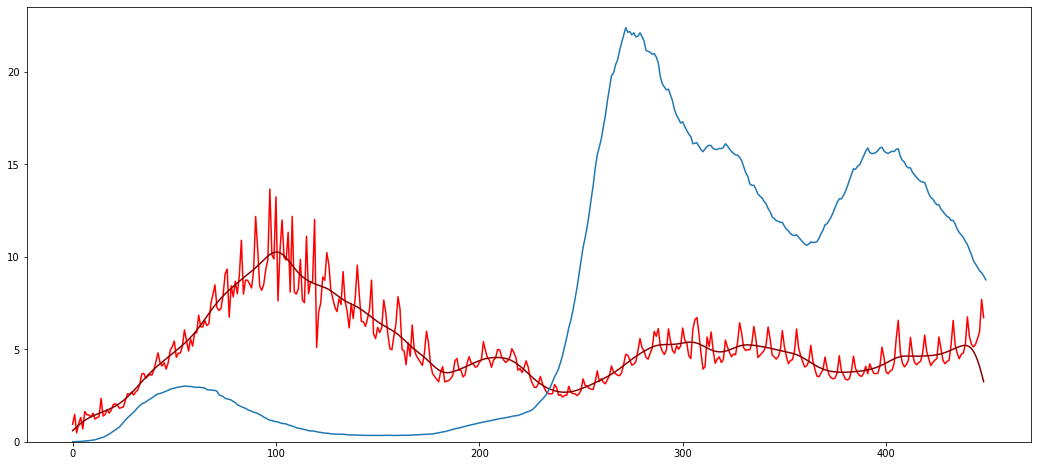

In [205]:
#betaTime = b0 + b1/(1 + (b2I+b3D)**b4)
#betaTime - b0 = b1/(1 + (b2I+b3D)**b4)
#(1 + (b2I+b3D)**b4) = b1/(betaTime - b0)
#(b1I + b2D) = (b1/(betaTime - b0) - 1)**(1/b4)
betaTran = ((.8 / (abs(betaTime) - .00)) - 1)**(1.0/2.0)
#print(betaTime)
matchTran = infect/(q*pop)

fig2, ax2 = plt.subplots(figsize=(18,8))
ax2.plot(betaTran, color='red')
ax2.plot(smoothOutLine(betaTran), color='darkred')
ax2.plot(matchTran*150)
#betaTran = smoothOutLine(betaTran)
ax2.set_ylim(0);

Solution: 
q:   0.09
b2:  50
b3:  0
b4:  3.0
b0:  0.04033798500687383
b1:  0.014265805755734249
g:   0.03197184742832586
nu:  0.0009870613269825164
cost:  103655557750614.88



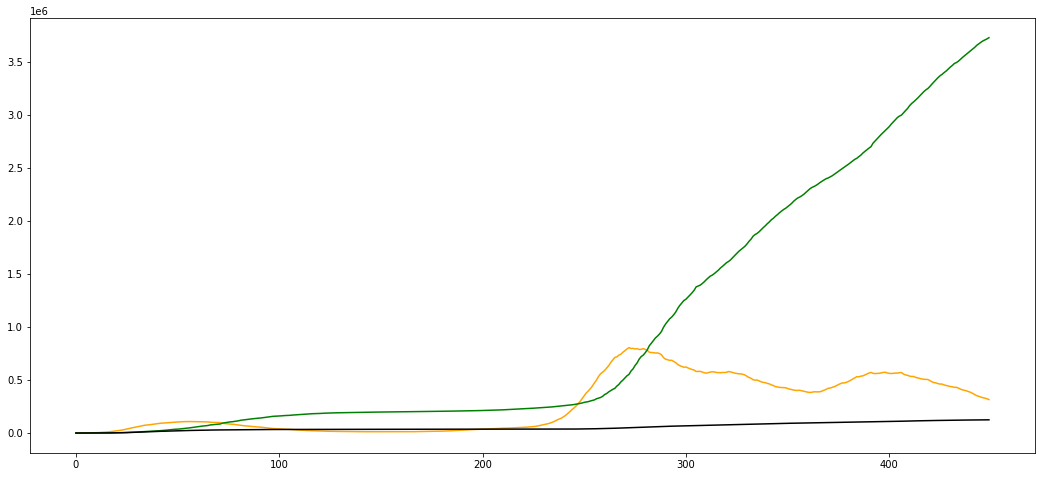

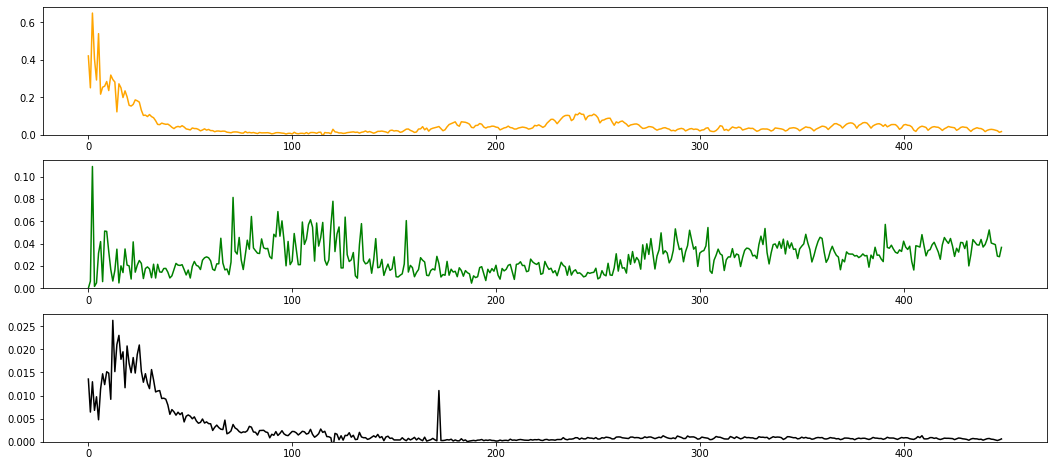

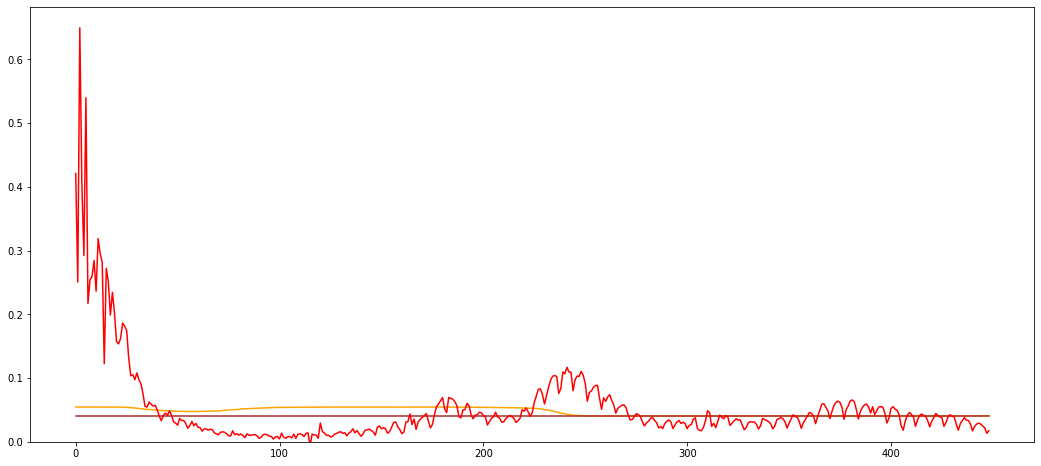

In [8]:
pathc = "../Data/Italian Data/"
#pathc="../Data/Covid Tracking State Data/"
# modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc.replace("/", "\\")
    
filename = "National Data.csv"
#filename = "AL.csv"
dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + filename)
#recovRaw = approxRecovered(infectRaw)
#infectRaw = infectRaw - recovRaw - deadRaw

pop = 60000000
#pop = 40000000
skipDays = 0
numDays = len(infectRaw) #max days
infect = infectRaw[skipDays:numDays]
recov = recovRaw[skipDays:numDays] 
dead = deadRaw[skipDays:numDays]

boundQ = (.09,.09) #q should be between 0 and 1
#Beta = b0 + b1/(1+(I*b2 + D*b3)^b4)
boundB1 = (50,1000)
boundB2 = (0,0)
boundB3 = (1,4)

lamda = 10 #regularization weight
wVal = 1 #weight decay, when w is 1 there is no decay (all days weighted equal)

constraints = [boundQ, boundB1, boundB2, boundB3]
varResol = [1,100,1,3] #resolution for each variable

constArg = (pop, infect, recov, dead, lamda, wVal)

nonLinVars, linVars = solveAllVars(constraints, varResol, *constArg)

#beta = b0 / 1 + (I*b1+D*b2)**b3
betaVars = [linVars[0], linVars[1], nonLinVars[1], nonLinVars[2], nonLinVars[3]]
q = nonLinVars[0]
beta = calculateBeta(betaVars, infect, recov, dead, pop, q)

#with diff(IRD), diff(D) 165704590.23082045, all zeros
#with (I), (D), 88031332.86333087, .0404, .406, 93, 85, 2.75
#with (I), (D), 88031351.32973273, .0404, .406, 92.33, 67.333, 2.2
#with (I), (D), 88031286.01273839.0404, .406, 468, 8, 3.4
#with (I+R+D) (D), .0404, .406, 42.5, 1.25, 3.4, 89...

paramMatrix = SIRD_Model.calculateAverageParams(infect, recov, dead, pop, q, graph=True, graphVals=[0,1,1,1])
betaTime = paramMatrix[:,0]

#fig, ax = plt.subplots(figsize=(18,8))
#ax.plot(infect[-1], color='orange', label='infect')
#ax.plot(dead[:-1], color='black', label='dead')


betaConst = SIRD_Model.calculateConstantParams(infect, recov, dead, pop, q)[0]
betaConstGraph = np.ones((len(beta)))*betaConst #fill array with const value
fig2, ax2 = plt.subplots(figsize=(18,8))
ax2.plot(beta, color='orange', label='Feedback Transmission Rate')
ax2.plot(betaConstGraph, color='brown', label="const beta")
ax2.plot(betaTime, color='red')
ax2.set_ylim(0);

Solution: 
q:   0.09
b2:  704.5
b3:  0
b4:  3.0
b0:  0.045397754962322526
b1:  0.05070386133166467
g:   0.029616004097622422
nu:  0.0012699403851139345
cost:  90303785.14325634

[0.04539785] 8.651726376565731e+25
[0.04539785] 8.34001536358898e+25
[0.04539785] 8.531994629330531e+25
[0.04539785] 8.7261770618916e+25
[0.04539784] 8.922489692138385e+25
[0.04539784] 9.12085470136675e+25
[0.04539784] 9.321189229258153e+25
[0.04539784] 9.523405309461197e+25
[0.04539784] 9.727409812931198e+25
[0.04539784] 9.933104399538792e+25
[0.04539783] 1.0140385478458994e+26
[0.04539783] 1.0349144177850635e+26
[0.04539783] 1.0559266324332582e+26
[0.04539783] 1.0770632432757761e+26
[0.04539783] 1.0983117706778023e+26
[0.04539783] 1.1196592050683106e+26
[0.04539782] 1.141092009298444e+26
[0.04539782] 1.1625961222199849e+26
[0.04539782] 1.1841569635277721e+26
[0.04539782] 1.2057594399079498e+26
[0.04539782] 1.227387952531665e+26
[0.04539782] 1.2490264059313155e+26
[0.04539782] 1.2706582182936433e+26
[0.0453978

C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:214: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


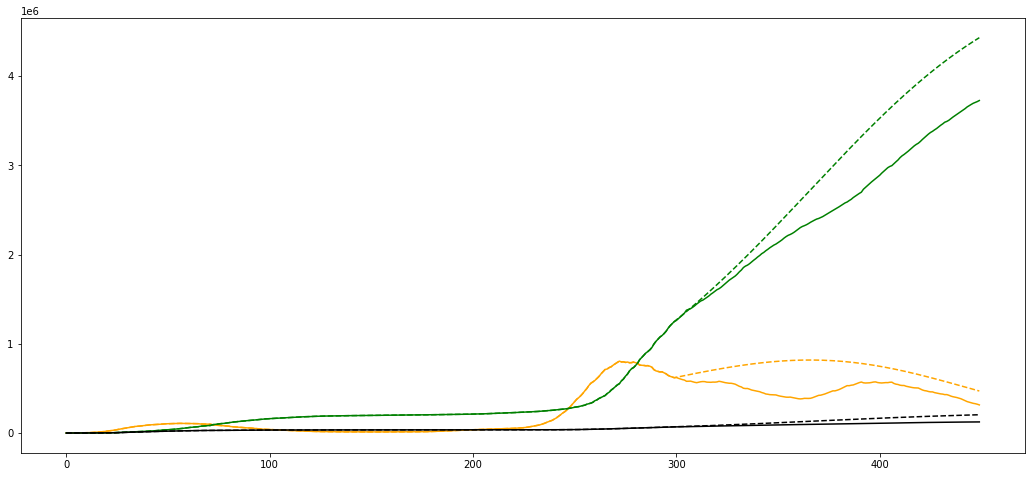

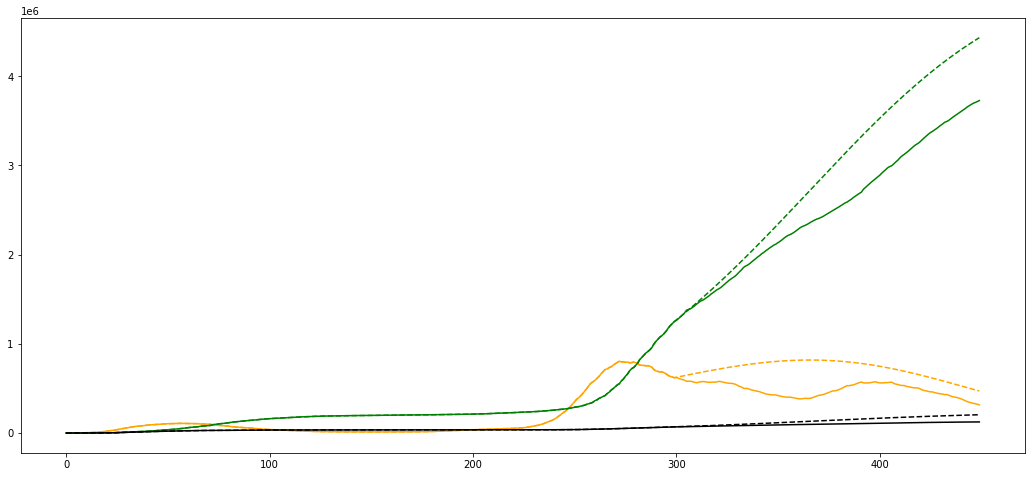

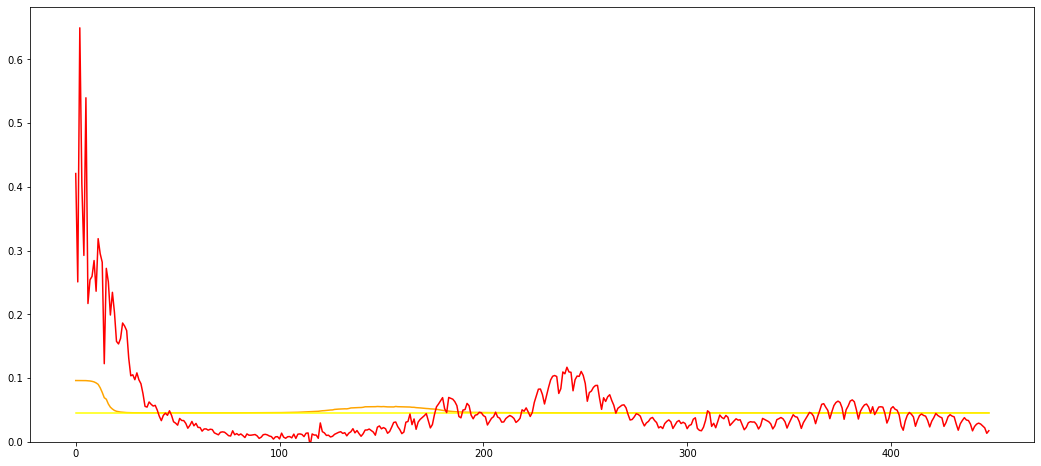

In [214]:
#predict 
pop = 60000000
q = .09
numDays = len(infectRaw)  #max days
skipDays = 0
infect = infectRaw[skipDays:numDays]
recov = recovRaw[skipDays:numDays]

dead = deadRaw[skipDays:numDays]
daysToPredict = 150

#don't use the days to predict to train on
constArg = (pop, infect[:-daysToPredict], recov[:-daysToPredict], dead[:-daysToPredict], lamda, wVal)
nonLinVars, linVars = solveAllVars(constraints, varResol, *constArg)

#beta = b0 / 1 + (I*b1+D*b2)**b3
betaVars = [linVars[0], linVars[1], nonLinVars[1], nonLinVars[2], nonLinVars[3]]
q = nonLinVars[0]
beta = calculateBeta(betaVars, infect, recov, dead, pop, q)

#feedback prediction
predictFeedMatch(infect, recov, dead, pop, daysToPredict, nonLinVars, linVars, graphVals=[0,1,1,1])

#constant prediction
constParams = SIRD_Model.calculateConstantParams(infect[:-daysToPredict], recov[:-daysToPredict], dead[:-daysToPredict], pop, q)
SIRD_Model.predictConstMatch(infect, recov, dead, pop, daysToPredict, constParams, q, graphVals=[0,1,1,1])


#plot beta feedback model vs actual
betaConstGraph = np.ones((len(beta)))*constParams[0] #fill array with const value

fig2, ax2 = plt.subplots(figsize=(18,8))
ax2.plot(beta, color='orange', label='Feedback Transmission Rate')
ax2.plot(betaConstGraph, color='yellow', label="const beta")
ax2.plot(betaTime[:len(beta)], color='red')
ax2.set_ylim(0);

[0.0, 0.04559019946801793, 50, 0, 3.0]


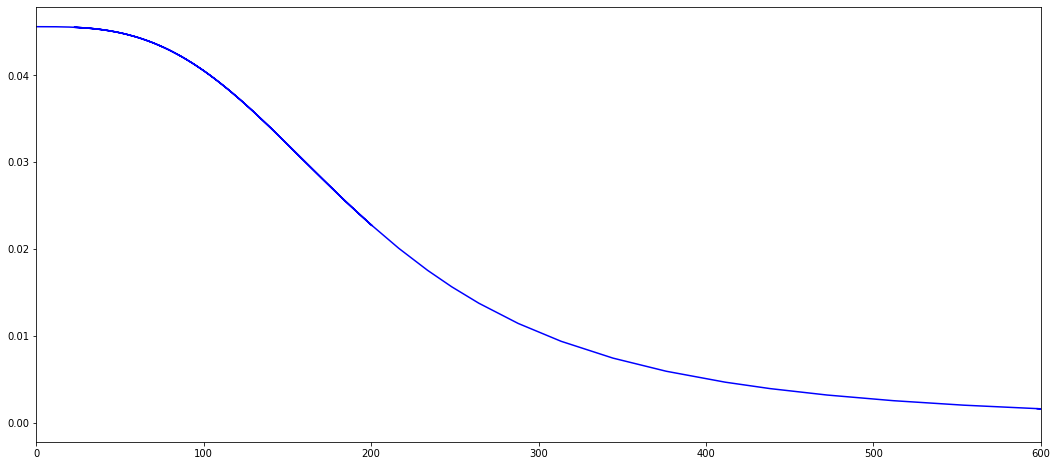

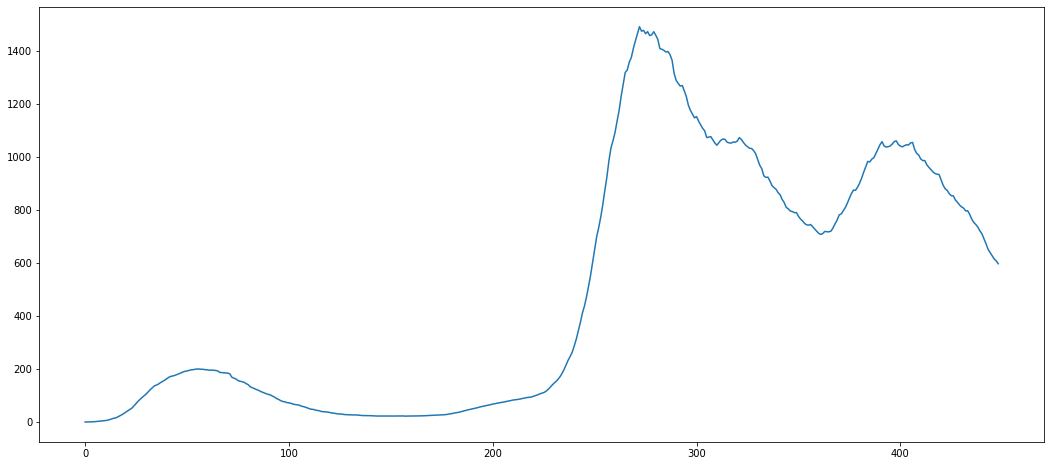

In [142]:
#graph feedback slope
betaX = (infect[:-1]/(q*pop)) + betaVars[3]/betaVars[2] * (dead[:-1]/(q*pop))
betaY = beta

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(10000*betaX,betaY, color='blue', label='beta by I + (b3/b2)*D') #per 10,000
ax.set_xlim([0,600])

fig2, ax2 = plt.subplots(figsize=(18,8))
ax2.plot((infect[:-1]/(q*pop))*10000) #per 10,000

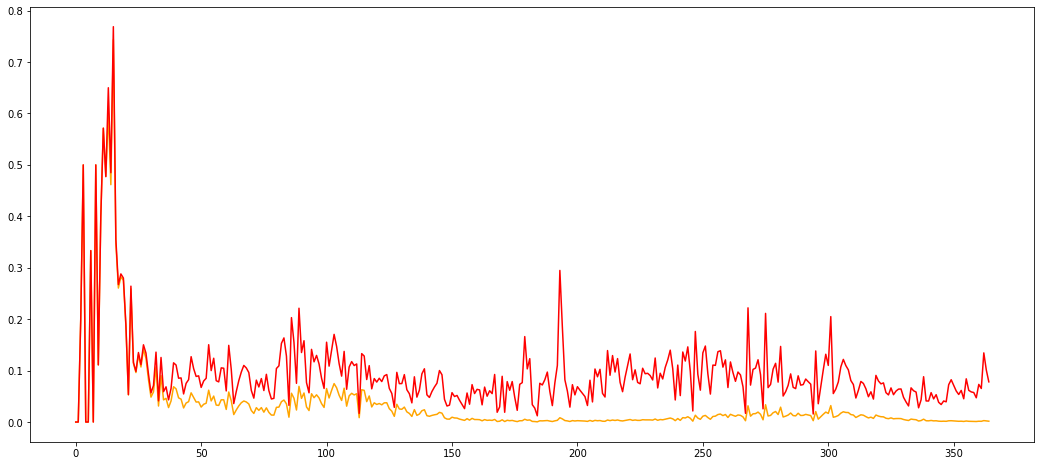

In [147]:
#pathc = "../Data/Italian Data/"
pathc="../Data/Covid Tracking State Data/"
# modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc.replace("/", "\\")
    
#filename = "National Data.csv"
filename = "AZ.csv"

dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + filename)
recovRaw = approxRecovered(infectRaw)
infectRaw = infectRaw - recovRaw - deadRaw

q = .09

pop = 60000000
skipDays = 0
numDays = len(infectRaw) #max days
infect = infectRaw[skipDays:numDays]
recov = recovRaw[skipDays:numDays] 
dead = deadRaw[skipDays:numDays]

paramMatrix = SIRD_Model.calculateAverageParams(infect, recov, dead, pop, q, graph=False)
betaTime = paramMatrix[:,0]

fig2, ax2 = plt.subplots(figsize=(18,8))
ax2.plot((infect+recov+dead)[1:]/(infect+recov+dead)[:-1] - 1, color='orange', label='relative daily infections')
ax2.plot(betaTime, color='red')
#ax2.plot(dead[1:]/dead[:-1], color='red')